# (Optional) Check hardware for available GPU

In this section, I am using tensorflow to check for available GPUs and (if possible) set memory growth across the GPUs

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Library and data import

In [2]:
import pandas as pd                                     # For reading and working with tabular csv data
import tensorflow as tf                                 # General machine learning functionalities
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence             # For creating data generators for training
import numpy as np
import matplotlib.pyplot as plt                         # To visualize model training process
from sklearn.model_selection import train_test_split

c:\Users\caomi\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Discovery and Processing

In [ ]:
# Old data, which was split into feature and label files
feature_csv_path = "data/inputs.csv"
label_csv_path = "data/outputs.csv"

# Load features and labels
features_df = pd.read_csv(feature_csv_path)
label_df = pd.read_csv(label_csv_path)

## Data inspection and discovery

In [4]:
print(f"Dimension of feature dataframe: ",features_df.shape)
INPUT_SHAPE = features_df.shape[1]                              # represents the input shape for the ANN

features_df.head(10)

Dimension of feature dataframe:  (10000, 3)


,Load History,Distance to Task,Total Distance Traveled
0,0.0,18.124,0.000
1,0.0,24.937,0.000
2,0.0,13.756,0.000
3,0.0,8.911,0.000
4,1.0,5.263,18.124
5,0.0,23.882,0.000
6,0.0,11.881,0.000
7,1.0,5.213,8.911
8,2.0,9.394,23.387
9,0.0,25.775,0.000


In [5]:
print(f"Dimension of label dataframe: ",label_df.shape)
label_df.head(10)

Dimension of label dataframe:  (10000, 1)


,Suitability
0,4.95
1,3.56
2,6.03
3,7.82
4,6.82
5,3.57
6,6.71
7,7.15
8,5.28
9,3.56


## Convert dataframe to numpy arrays

In [6]:
features_array = features_df.to_numpy()
label_array = label_df.to_numpy()

## Train-Test Split

In [7]:
# Split the training data to test set and (train+validation) set
X_train, X_test, y_train, y_test = train_test_split(features_array,
                                                    label_array,
                                                    test_size=0.2,
                                                    random_state=12)

# Split the (train + validation) set to train set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=12)

In [8]:
print(f"There are {X_train.shape[0]} samples in the train set\n"
      f"There are {X_val.shape[0]} samples in the validation set\n"
      f"There are {X_test.shape[0]} samples in the test set")

There are 6400 samples in the train set
There are 1600 samples in the validation set
There are 2000 samples in the test set


In [9]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y
    
BATCH_SIZE = 32

# These generator objects will generate BATCH_SIZE samples at a time from the specified nparray
train_gen = DataGenerator(X_train,y_train,BATCH_SIZE)
val_gen = DataGenerator(X_val,y_val,BATCH_SIZE)
test_gen = DataGenerator(X_test,y_test,BATCH_SIZE)

# Model Construction

In [10]:
def build_model(layer_widths, input_shape, activation='relu', learning_rate=0.001):
    """
    Creates a Keras Sequential model based on the specified architecture.

    Args:
        layer_widths (list): A list where each element is the number of nodes in a layer.
        input_shape (tuple): Shape of the input data (e.g., (num_features,)).
        activation (str): Activation function to use in the hidden layers.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        model (Sequential): A compiled Keras Sequential model.
    """
    model = keras.Sequential()

    # Add additional hidden layers based on layer_widths
    for i,width in enumerate(layer_widths):
        if i==0: 
            model.add(layers.Dense(width, activation=activation, input_shape=input_shape))
        else: 
            model.add(layers.Dense(width, activation=activation))
        model.add(layers.BatchNormalization())

    # Add the output layer (no activation for regression)
    model.add(layers.Dense(1,name = "Output_layer"))

    # Compile the model with a regression-friendly loss function
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss='mse', 
                  metrics=['mae',keras.metrics.RootMeanSquaredError()])
    
    return model

layer_widths = [64,32,16,1]
LEARNING_RATE = 0.001
EPOCH = 50
tf.keras.backend.clear_session()
model = build_model(layer_widths = layer_widths,
                    input_shape= (INPUT_SHAPE,),
                    learning_rate=LEARNING_RATE)

history = model.fit(train_gen,
                    batch_size=BATCH_SIZE,
                    validation_data=val_gen,
                    epochs = EPOCH)

Epoch 1/50
200/200 [==============================] - 3s 7ms/step - loss: 20.5996 - mae: 4.4497 - root_mean_squared_error: 4.5387 - val_loss: 17.7890 - val_mae: 4.1546 - val_root_mean_squared_error: 4.2177
Epoch 2/50
200/200 [==============================] - 1s 7ms/step - loss: 16.2653 - mae: 3.9923 - root_mean_squared_error: 4.0330 - val_loss: 12.0984 - val_mae: 3.4584 - val_root_mean_squared_error: 3.4783
Epoch 3/50
200/200 [==============================] - 1s 7ms/step - loss: 12.1154 - mae: 3.4432 - root_mean_squared_error: 3.4807 - val_loss: 8.4572 - val_mae: 2.8839 - val_root_mean_squared_error: 2.9081
Epoch 4/50
200/200 [==============================] - 1s 7ms/step - loss: 8.1801 - mae: 2.8151 - root_mean_squared_error: 2.8601 - val_loss: 5.1048 - val_mae: 2.2426 - val_root_mean_squared_error: 2.2594
Epoch 5/50
200/200 [==============================] - 1s 7ms/step - loss: 4.8478 - mae: 2.1475 - root_mean_squared_error: 2.2018 - val_loss: 3.0143 - val_mae: 1.7091 - val_root_me

In [ ]:
def plot_performance(history, learning_rate=None, batch_size=None, finetune_epochs=None):
    # Determine whether history is keras history or a dictionary to appropriately extract the history data
    if isinstance(history, keras.callbacks.History):
        history_data = history.history        # Extract the history dictionary
    else:
        history_data = history                # Assume it's already a dictionary

    metric_list = list(history_data.keys())     # Extract the list of history keys
    half_length = len(metric_list) // 2         # The index where the validation metrics start

    metric2txt_dict = {'mae': "Mean Absolute Error",
                       'root_mean_squared_error': "Root Mean Square Error",
                       'loss': 'Loss'}

    plt.figure(figsize=(half_length * 5,5))

    for index, metric in enumerate(metric_list[:half_length]):
        metric_train = metric
        metric_val = metric_list[index+half_length]

        plt.subplot(1,half_length,index+1)
        ylim_acc = [0, max(max(history_data[metric_train]),max(history_data[metric_val]))]
        plt.plot(history_data[metric_train], label = metric_train)
        plt.plot(history_data[metric_val], label = metric_val)
        plt.ylim(ylim_acc)
        # plt.ylabel(metric_train)
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
        if learning_rate and batch_size:
            plt.title(f'{metric2txt_dict[metric_train]} \n lr = {learning_rate}, batch size = {batch_size}')
        else: plt.title(f'{metric2txt_dict[metric_train]}')

        plt.grid(which='major', color='black', linestyle='--', linewidth=0.5)

        # Enable the minor grid
        plt.minorticks_on()  # Turn on the minor ticks
        plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)


    return metric_list

['loss',
 'mae',
 'root_mean_squared_error',
 'val_loss',
 'val_mae',
 'val_root_mean_squared_error']

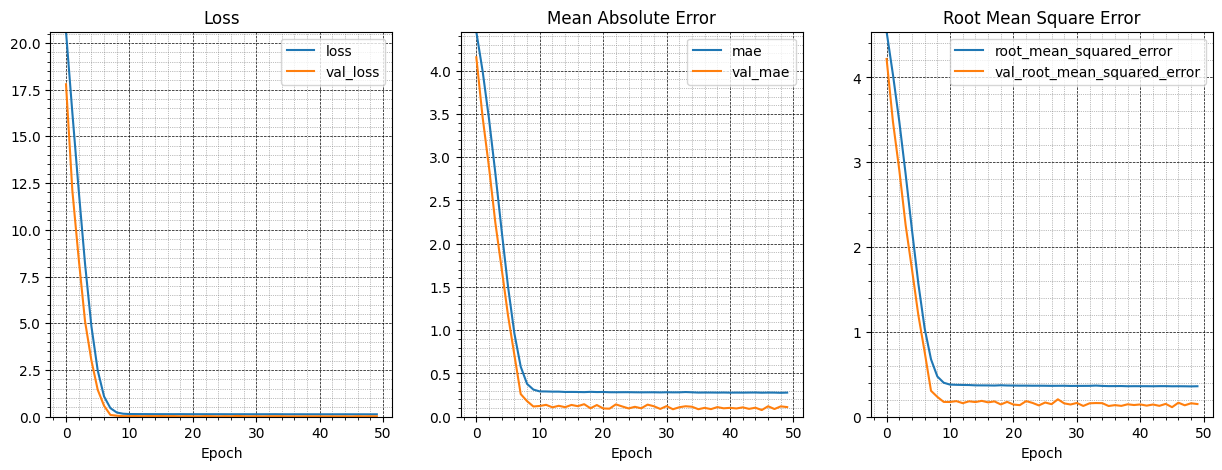

In [24]:
plot_performance(history)

# Model prediction and performance

In [26]:
model.evaluate(test_gen)

63/63 [==============================] - 0s 3ms/step - loss: 0.0231 - mae: 0.1089 - root_mean_squared_error: 0.1518


[0.023056894540786743, 0.10886503010988235, 0.15184496343135834]

In [27]:
y_pred = model.predict(X_test)

63/63 [==============================] - 0s 2ms/step


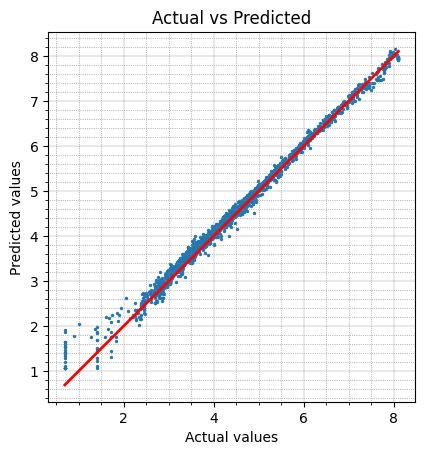

In [30]:
# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred,s=2)

# Line showing perfect prediction (if predicted = actual)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted')

plt.grid(which='major', color='gray', linestyle='-', linewidth=0.25)
plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)
plt.minorticks_on()

plt.show()

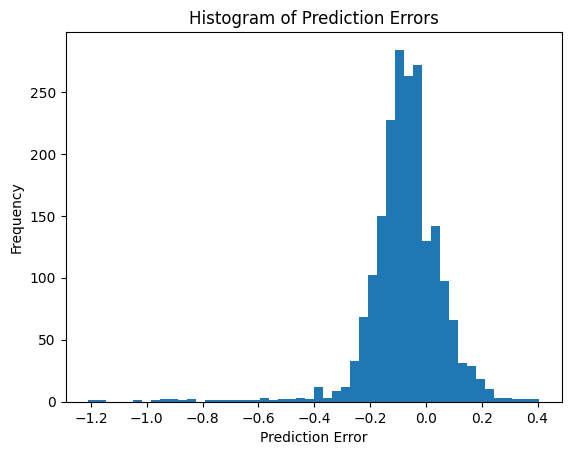

In [32]:
errors = y_test - y_pred
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

# Save the Model

In [34]:
model_directory = 'model/model.h5'

# Save the model in HDF5 format
model.save(model_directory)

# Load the Model

In [35]:
from tensorflow.keras.models import load_model
loaded_model = load_model(model_directory)

In [37]:
y_loaded_pred = loaded_model.predict(X_test)

63/63 [==============================] - 0s 2ms/step


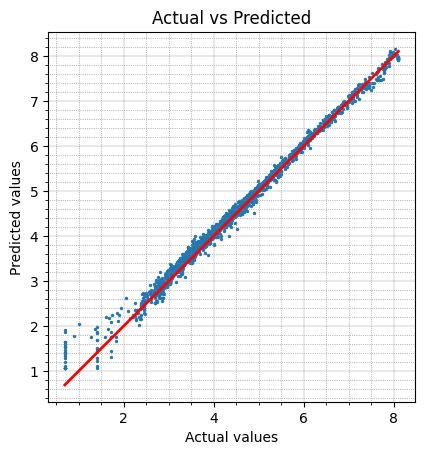

In [38]:
# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_loaded_pred,s=2)

# Line showing perfect prediction (if predicted = actual)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted')

plt.grid(which='major', color='gray', linestyle='-', linewidth=0.25)
plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)
plt.minorticks_on()

plt.show()